In [2]:
pip install livelossplot

# **Imports & Constants**

In [0]:
import numpy as np
import cv2
import glob
import random
from shapely.geometry.point import Point
from skimage.draw import circle_perimeter_aa
from os import path

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.engine.saving import load_model
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import keras.backend as kb
from livelossplot.keras import PlotLossesCallback

MAIN_DIR_PATH = "drive/My Drive/Colab Notebooks/assignment3"
LOGS = MAIN_DIR_PATH + "/logs"
IMG_WIDTH = 200
IMG_HEIGHT = 200

from google.colab import drive

**Mount Google Drive**

In [5]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# **Main Function Definitions**

In [0]:
def draw_circle(img, row, col, rad):
    rr, cc, val = circle_perimeter_aa(row, col, rad)
    valid = (
        (rr >= 0) &
        (rr < img.shape[0]) &
        (cc >= 0) &
        (cc < img.shape[1])
    )
    img[rr[valid], cc[valid]] = val[valid]


def noisy_circle(size, radius, noise):
    img = np.zeros((size, size), dtype=np.float)

    # Circle
    row = np.random.randint(size)
    col = np.random.randint(size)
    rad = np.random.randint(10, max(10, radius))
    draw_circle(img, row, col, rad)

    # Noise
    img += noise * np.random.rand(*img.shape)
    return (row, col, rad), img


def find_circle(model, img):
    """
    Finds the circle in the given img using the model's prediction. 
    
    Returns the (rows, cols, radius) of the circle, image with circle drawn, predicted mask mask by model
    
    :param model: the model to predict the circle
    :param img: the image on which to find the circle
    """
    row, col, rad = 0, 0, 0

    # Get prediction
    y_pred = model.predict(np.expand_dims(img.reshape(img.shape[0], img.shape[1], 1), axis=0))

    p_mask = y_pred.squeeze()
    p_mask[p_mask >= 0.5] = 255
    p_mask[p_mask < 0.5] = 0
    p_mask = p_mask.astype(np.uint8)

    # Apply cv2.threshold() to get a binary image
    _, thresh = cv2.threshold(p_mask, 50, 255, cv2.THRESH_BINARY)

    # Detect circles in the image
    circles = cv2.HoughCircles(thresh, method=cv2.HOUGH_GRADIENT, dp=1, minDist=thresh.shape[0] / 2, param1=10,
                               param2=8)

    n_img = img.copy()
    # Ensure at least some circles were found
    if circles is not None:
        # Convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
        # Loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circles:
            row, col, rad = y, x, r
            cv2.circle(n_img, (x, y), r, (0, 255, 0), 2)

    return (row, col, rad), n_img, thresh


def iou(params0, params1):
    row0, col0, rad0 = params0
    row1, col1, rad1 = params1

    shape0 = Point(row0, col0).buffer(rad0)
    shape1 = Point(row1, col1).buffer(rad1)

    return (
        shape0.intersection(shape1).area /
        shape0.union(shape1).area
    )


def binary_circle_mask(size, params):
    """
    Generates a binary mask for the given circle.
    
    :param size: the size of the mask
    :param params: the parameters of the circle (row, col, rad)
    """
    img = np.zeros((size, size), dtype=np.float)
    row, col, rad = params
    draw_circle(img, row, col, rad)
    return img


def main(model=None):
    results = []
    if model is None:
      model = generate_predictor()
    for i in range(10):
        params, img = noisy_circle(200, 50, 2)
        detected_params, new_img, mask = find_circle(model, img)

        int_over_uni = iou(params, detected_params)
        results.append(int_over_uni)

        figure = plt.figure(figsize=(10, 10))
        plt.subplot(231), plt.imshow(img)
        plt.subplot(232), plt.imshow(new_img)
        plt.subplot(233), plt.imshow(mask)
        plt.title("IOU: " + str(int_over_uni))
        plt.show()
        figure.savefig(MAIN_DIR_PATH + "/result_" + str(i) + ".png", dpi=100, bbox_inches='tight')

    results = np.array(results)
    print("Mean IOU: " + str((results > 0.7).mean()))

# **Visualize Function Definitions**

In [0]:
def plot_model_history(model_results):
    """
    Plots Loss and Accuracy graphs for the given model results.

    :param model_results: the model results from which to retrieve graph data
    """
    plt.figure(figsize=(8, 9))

    plt.subplot(2, 1, 1)
    if "loss" in model_results.history.keys():
        plt.plot(model_results.history["loss"], label="Training Loss")
    if "val_loss" in model_results.history.keys():
        plt.plot(model_results.history["val_loss"], label="Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.title("Training and Validation Loss")

    plt.subplot(2, 1, 2)
    if "acc" in model_results.history.keys():
        plt.plot(model_results.history["acc"], label="Training Accuracy")
    if "val_acc" in model_results.history.keys():
        plt.plot(model_results.history["val_acc"], label="Validation Accuracy")
    if "dice_coef" in model_results.history.keys():
        plt.plot(model_results.history['dice_coef'], label="Dice Coefficient")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.title("Training and Validation Accuracy")

    plt.show()


def visualize_segmentations_with_contours(images, ground_masks, pred_masks, save_path=""):
    """
    Visualizes the predicted masks by drawing them as contours on their corresponding images.

    :param images: the list of images
    :param ground_masks: the list of ground truth masks for the image
    :param pred_masks: the list of predicted masks for the image
    :param save_path: path to save all the images (if empty, then images won't be saved)
    """
    for i in range(len(pred_masks)):
        p_mask = pred_masks[i].squeeze()
        p_mask[p_mask >= 0.5] = 255
        p_mask[p_mask < 0.5] = 0
        p_mask = p_mask.astype(np.uint8)

        # Apply cv2.threshold() to get a binary image
        _, thresh = cv2.threshold(p_mask, 50, 255, cv2.THRESH_BINARY)
        img = images[i].copy()

        # detect circles in the image
        circles = cv2.HoughCircles(thresh, method=cv2.HOUGH_GRADIENT, dp=1, minDist=thresh.shape[0]/2, param1=10, param2=8)

        # Ensure at least some circles were found
        if circles is not None:
            # Convert the (x, y) coordinates and radius of the circles to integers
            circles = np.round(circles[0, :]).astype("int")

            # Loop over the (x, y) coordinates and radius of the circles
            for (x, y, r) in circles:
                # Draw the circle in the output image
                cv2.circle(img, (x, y), r, (0, 255, 0), 2)

        figure = plt.figure(figsize=(10, 10))
        plt.subplot(231), plt.imshow(images[i].squeeze())
        plt.subplot(222), plt.imshow(img.squeeze())

        plt.show()
        if save_path is not None or save_path != "":
            figure.savefig(save_path + "/result_" + str(i) + ".png", dpi=100, bbox_inches='tight')

# **Model Funcion Definitions**

In [0]:
def conv2d_block(name, x, filters, kernel_size, padding, activation):
    conv = Conv2D(name=name, filters=filters, kernel_size=kernel_size, padding=padding)(x)
    conv = BatchNormalization()(conv)
    conv = Activation(activation=activation)(conv)
    return conv


def circle_model(input_size):
    inputs = Input(name="input1", shape=input_size)
    conv1 = conv2d_block(name="conv1", x=inputs, filters=64, kernel_size=3, padding="same", activation="relu")
    maxpool1 = MaxPool2D(name="maxpool1", pool_size=(2, 2), strides=2)(conv1)

    conv2 = conv2d_block(name="conv2", x=maxpool1, filters=128, kernel_size=3, padding="same", activation="relu")
    maxpool2 = MaxPool2D(name="maxpool2", pool_size=(2, 2), strides=2)(conv2)

    conv3 = conv2d_block(name="conv3", x=maxpool2, filters=256, kernel_size=3, padding="same", activation="relu")
    upconv1 = UpSampling2D(name="upconv1", size=(2, 2))(conv3)

    concat1 = concatenate(name="concat1", inputs=[conv2, upconv1], axis=3)
    conv4 = conv2d_block(name="conv4", x=concat1, filters=128, kernel_size=3, padding="same", activation="relu")
    upconv2 = UpSampling2D(name="upconv2", size=(2, 2))(conv4)

    concat2 = concatenate(name="concat2", inputs=[conv1, upconv2], axis=3)
    conv5 = conv2d_block(name="conv5", x=concat2, filters=64, kernel_size=3, padding="same", activation="relu")

    conv6 = Conv2D(name="conv6", filters=1, kernel_size=1, activation="sigmoid")(conv5)
    u_model = Model(input=inputs, output=conv6)

    u_model.summary()

    return u_model

# **Training Function Definitions**

In [0]:
def test_model(model, test_x, test_y, visualize_func=None):
    """
    Tests the model on the given data and optionally visualizes it.

    :param model: the model to test with
    :param test_x: input data (ie. test_x)
    :param test_y: output data (ie. test_y)
    :param visualize_func: a function that takes (images, ground_masks, pred_masks, save_path) and visualizes them
    """
    pred_y = model.predict(test_x)

    if visualize_func is not None:
        visualize_func(test_x, test_y, pred_y, MAIN_DIR_PATH + "/results")


def train_model(train_x, train_y, model_name="circle_model", augment=False, lr=1e-4, epochs=10, valid_split=0,
                early_stop=False, model=None):
    """
    Returns a trained model and the training history.

    :param input_path: path to all the input data (ie. train_X)
    :param output_path: path to all the output data (ie. train_y)
    :param augment: whether or not the augment the data
    :param model_name: name of the new model (weights will be saved under this name)
    :param lr: learning rate for model
    :param epochs: number of epochs to run for
    :param valid_split: percentage of data that should be used for validation
    :param early_stop: whether or not to stop early if the validation and training curves diverge too much
    :param model: an existing model to train
    """
    if model is None:
        model = circle_model((IMG_WIDTH, IMG_HEIGHT, 1))
        model.compile(optimizer=Adam(lr=lr), loss="binary_crossentropy", metrics=["accuracy"])

    # Setup training callbacks
    callbacks = []
    if early_stop:
        callbacks.append(EarlyStopping(monitor='val_loss', verbose=1, patience=50))
    callbacks.append(ModelCheckpoint(MAIN_DIR_PATH + "/" + model_name + ".hdf5", save_weights_only=True))
    callbacks.append(PlotLossesCallback())

    history = model.fit(train_x, train_y, epochs=epochs, validation_split=valid_split, callbacks=callbacks)

    plot_model_history(history)

    return model, history

# **Training**

In [75]:
def generate_predictor():
    train_x = []
    train_y = []
    # Start be getting some training data
    for i in range(1000):
        params, img = noisy_circle(200, 50, 2)
        mask = binary_circle_mask(200, params)
        
        train_x.append(img.reshape((img.shape[0], img.shape[1], 1)))
        train_y.append(mask.reshape((mask.shape[0], mask.shape[1], 1)))

    train_x = np.array(train_x)
    train_y = np.array(train_y)
    return train_model(train_x=train_x, train_y=train_y, model_name="circle_model", augment=False, lr=1e-4, epochs=100,
                       valid_split=0.1, early_stop=True)
    

c_model, c_history = generate_predictor()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 200, 200, 64) 640         input1[0][0]                     
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 200, 200, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_61 (Activation)      (None, 200, 200, 64) 0           batch_normalization_61[0][0]     
___________________________________________________________________________________________

KeyboardInterrupt: ignored

# **Testing**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Model: "model_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 200, 200, 64) 640         input1[0][0]                     
__________________________________________________________________________________________________
batch_normalization_216 (BatchN (None, 200, 200, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_216 (Activation)     (None, 200, 200, 64) 0           batch_normalization_216[0][0]    
___________________________________________________________________________________________

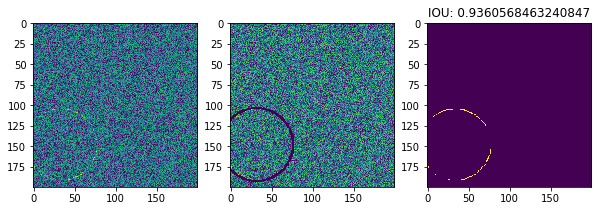

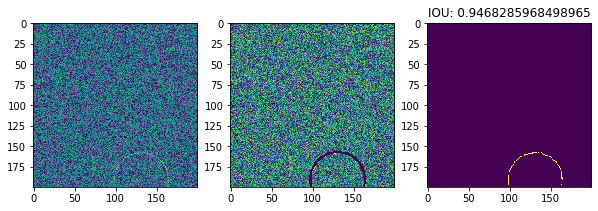

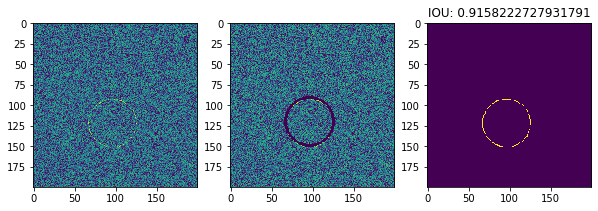

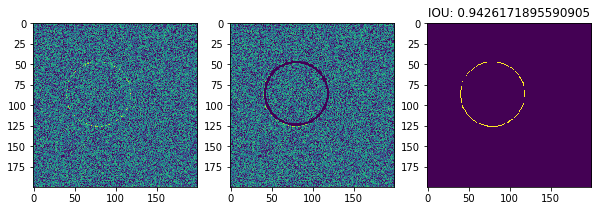

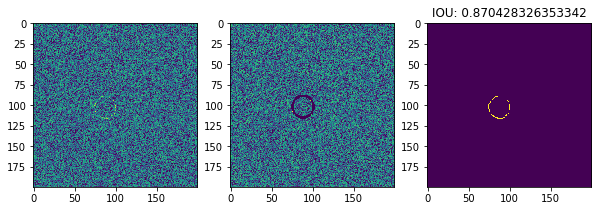

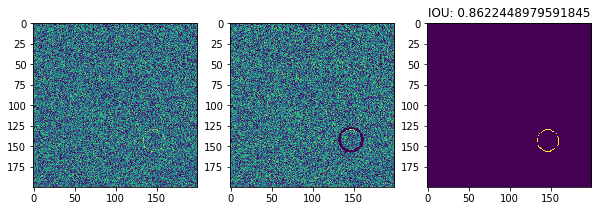

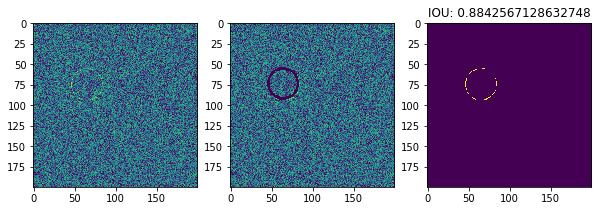

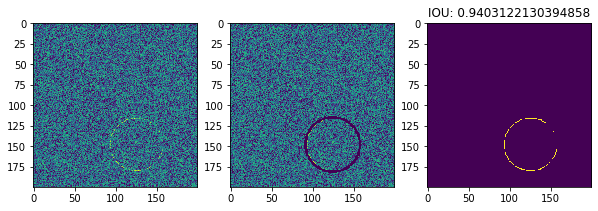

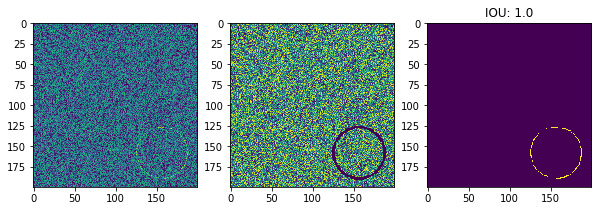

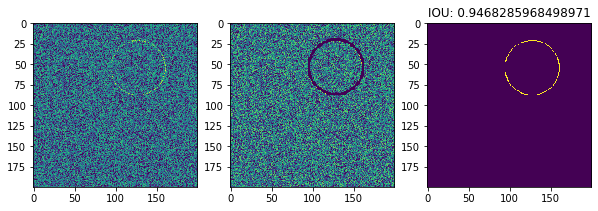

Mean IOU: 1.0


In [99]:
c_model = circle_model((200, 200, 1))
c_model.load_weights(MAIN_DIR_PATH + "/circle_model.hdf5")
main(c_model)